In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [3]:
path_tr='/content/drive/MyDrive/zonenet/input_data/file_tr.csv'
path_val='/content/drive/MyDrive/zonenet/input_data/file_val.csv'
path_tst='/content/drive/MyDrive/zonenet/input_data/file_tst.csv'

EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [4]:
df_tr = pd.read_csv(path_tr)
df_val = pd.read_csv(path_val)
df_tst = pd.read_csv(path_tst)
print(df_tr.shape)
df_tr.head(2)

(334, 20)


,timestep,firing_rates,setpoints,flowpattern,q_enthalpy,tG_gaszone,tS_furnace,tS_obstacle,w_flux_furnace,w_flux_obstacle,nodetmp_1d_furnace,nodetmp_2d_obstacle,corrcoeff_b,Qconvi,extinctioncoeff_k,gasvolumes_Vi,QfuelQa_sum,surfareas_Ai,emissivity_epsi,convection_flux_qconvi
0,1005015,"[0.0, 0.9, 0.507]","[1228.0, 1493.0, 1523.0]","[0.24408, 0.00033, 0.0, 0.0, 0.09992, 0.00668,...","[264659.625, 5701.172, 15046.516, 18962.078, 2...","[1154.929, 667.527, 683.451, 735.837, 801.661,...","[937.438, 727.792, 711.038, 746.487, 804.916, ...","[53.419, 40.889, 36.936, 39.988, 42.808, 42.80...","[-4385.452, -822.878, -445.388, -601.827, -861...","[38961.855, 20849.539, 93180.945, 80582.922, 8...","[937.438, 710.18, 491.902, 273.783, 55.564, 72...","[59.838, 31.739, 30.059, 30.965, 47.338, 50.19...","[0.717, -0.231, 0.459, -0.078, 0.12, 0.013, -0...","[105589.953, 13229.063, 11730.326, 12516.344, ...","[0.035, 0.178, 0.625, 0.768, 25.748, 25.891]","[0.61, 0.581, 0.458, 0.458, 0.447, 0.681, 0.79...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.325, 0.312, 0.256, 0.256, 0.251, 0.388, 0.4...","[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...","[-4385.452, -822.878, -445.388, -601.827, -861..."
1,1005030,"[0.0, 0.9, 0.5]","[1228.0, 1493.0, 1523.0]","[0.24301, 0.00024, 0.0, 0.0, 0.09915, 0.00668,...","[262802.844, 5816.25, 15003.266, 18859.625, 22...","[1153.639, 666.38, 683.088, 735.567, 801.377, ...","[934.249, 727.015, 710.496, 745.808, 803.988, ...","[79.299, 57.298, 52.079, 57.967, 61.661, 61.66...","[-4201.41, -859.177, -456.041, -597.59, -841.8...","[38426.961, 20458.959, 91917.609, 79642.922, 8...","[934.249, 710.183, 491.902, 273.783, 55.564, 7...","[91.591, 45.583, 40.079, 42.927, 69.655, 73.21...","[0.717, -0.231, 0.459, -0.078, 0.12, 0.013, -0...","[103801.781, 13327.563, 11663.066, 12396.148, ...","[0.035, 0.178, 0.625, 0.768, 25.748, 25.891]","[0.61, 0.581, 0.458, 0.458, 0.447, 0.681, 0.79...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.325, 0.312, 0.256, 0.256, 0.251, 0.388, 0.4...","[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...","[-4201.41, -859.177, -456.041, -597.59, -841.8..."


In [5]:


def get_field_matrix(reqfield,df):
    for i in range(1,df.shape[0]):
        if i==1:
            tmp=eval(df.loc[i,reqfield])
            X=np.vstack([eval(df.loc[0,reqfield]),tmp])
        else:
            tmp=eval(df.loc[i,reqfield])
            X=np.vstack([X,tmp])
    print(X.shape)
    # print(X)
    return X

Xtr_fr=get_field_matrix('firing_rates',df_tr)
ytr_tG=get_field_matrix('tG_gaszone',df_tr)
ytr_tS_fur=get_field_matrix('tS_furnace',df_tr)
ytr_tS_obs=get_field_matrix('tS_obstacle',df_tr)

Xtr=Xtr_fr
ytr=np.hstack([ytr_tG,ytr_tS_fur,ytr_tS_obs])
# print(Xtr.shape)
# print(ytr.shape)

(334, 3)
(334, 24)
(334, 76)
(334, 102)


In [6]:
Xval_fr=get_field_matrix('firing_rates',df_val)
yval_tG=get_field_matrix('tG_gaszone',df_val)
yval_tS_fur=get_field_matrix('tS_furnace',df_val)
yval_tS_obs=get_field_matrix('tS_obstacle',df_val)

Xval=Xval_fr
yval=np.hstack([yval_tG,yval_tS_fur,yval_tS_obs])

Xtst_fr=get_field_matrix('firing_rates',df_tst)
ytst_tG=get_field_matrix('tG_gaszone',df_tst)
ytst_tS_fur=get_field_matrix('tS_furnace',df_tst)
ytst_tS_obs=get_field_matrix('tS_obstacle',df_tst)

Xtst=Xtst_fr
ytst=np.hstack([ytst_tG,ytst_tS_fur,ytst_tS_obs])

(334, 3)
(334, 24)
(334, 76)
(334, 102)
(334, 3)
(334, 24)
(334, 76)
(334, 102)


In [7]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = RegressionDataset(torch.from_numpy(Xtr).float(), torch.from_numpy(ytr).float())
val_dataset = RegressionDataset(torch.from_numpy(Xval).float(), torch.from_numpy(yval).float())
test_dataset = RegressionDataset(torch.from_numpy(Xtst).float(), torch.from_numpy(ytst).float())

In [8]:
NUM_FEATURES = Xtr.shape[1]
NUM_OUTPUTS = ytr.shape[1]
print(NUM_FEATURES,NUM_OUTPUTS)

3 202


In [9]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [10]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features,num_outputs):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 12)
        self.layer_2 = nn.Linear(12, 96)
        self.layer_out = nn.Linear(96, num_outputs)
        
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return (x)

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return (x)


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = MultipleRegression(NUM_FEATURES,NUM_OUTPUTS)
model.to(device)

# print(model)


cpu


MultipleRegression(
  (layer_1): Linear(in_features=3, out_features=12, bias=True)
  (layer_2): Linear(in_features=12, out_features=96, bias=True)
  (layer_out): Linear(in_features=96, out_features=202, bias=True)
  (relu): ReLU()
)

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
loss_stats = {
    'train': [],
    "val": []
}

In [14]:
# ## DUMMY debugging code

# for i in range(1, 100, 2):
#     dx_train = torch.tensor([i, i + 1]).reshape(2, 1).float()
#     dy_train = torch.tensor([[j, 2 * j, 3 * j] for j in dx_train]).float()
# print(dx_train.size(),dy_train.size())

# class MultiOutputRegression(torch.nn.Module):

#     def __init__(self):
#         super(MultiOutputRegression, self).__init__()
#         self.linear1 = torch.nn.Linear(1, 10)
#         self.linear2 = torch.nn.Linear(10, 10)
#         self.linear3 = torch.nn.Linear(10, 3)

#     def forward(self, x):
#         x = self.linear1(x)
#         x = self.linear2(x)
#         x = self.linear3(x)
#         return x

# model = MultiOutputRegression()

# dy_pred = model(dx_train)
# loss = criterion(dy_pred, dy_train)

# print(dy_pred.size(),loss)

# # torch.Size([2, 1]) torch.Size([2, 3])
# # torch.Size([2, 3]) tensor(47914.6992, grad_fn=<MseLossBackward0>)

In [15]:
# # ## DUMMY debugging code
# X_train_batch, y_train_batch=next(iter(train_loader))
# print(X_train_batch.size(),y_train_batch.size())
# # torch.Size([64, 3]) torch.Size([64, 202])

In [16]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 963851.66667 | Val Loss: 963508.38043
Epoch 002: | Train Loss: 962736.08333 | Val Loss: 963356.70771
Epoch 003: | Train Loss: 962316.23958 | Val Loss: 963174.49813
Epoch 004: | Train Loss: 962755.43750 | Val Loss: 962953.00468
Epoch 005: | Train Loss: 961707.37500 | Val Loss: 962684.06549
Epoch 006: | Train Loss: 962158.80208 | Val Loss: 962359.61003
Epoch 007: | Train Loss: 960789.58333 | Val Loss: 961971.37126
Epoch 008: | Train Loss: 961258.68750 | Val Loss: 961510.60086
Epoch 009: | Train Loss: 959609.32292 | Val Loss: 960967.87257
Epoch 010: | Train Loss: 960056.89583 | Val Loss: 960332.36976
Epoch 011: | Train Loss: 959301.52083 | Val Loss: 959590.50430
Epoch 012: | Train Loss: 958437.85417 | Val Loss: 958725.48297
Epoch 013: | Train Loss: 957245.57292 | Val Loss: 957721.72156
Epoch 014: | Train Loss: 956712.34375 | Val Loss: 956564.33234
Epoch 015: | Train Loss: 955290.93750 | Val Loss: 955238.85311
Epoch 016: | Train Loss: 953513.65625 | Val Loss: 95373

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

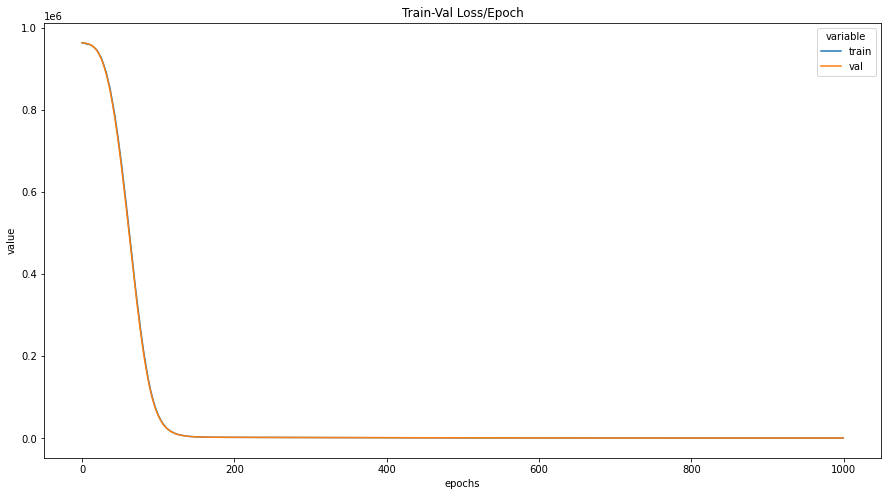

In [17]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [18]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        # print(y_test_pred.size())
        y_pred_list.append(y_test_pred.cpu().numpy())

for i in range(1,len(y_pred_list)):
    if i==1:
        ytst_pred_mat=np.vstack([y_pred_list[0],y_pred_list[i]])
    else:
        ytst_pred_mat=np.vstack([ytst_pred_mat,y_pred_list[i]])
print(ytst_pred_mat.shape)
print('predicted temperatures:')
print(ytst_pred_mat)
print('actual temperatures:')
print(ytst)



(334, 202)
predicted temperatures:
[[1245.6157   680.26965  699.25696 ... 1242.1381  1227.1663  1227.1646 ]
 [1246.2292   680.6028   699.60266 ... 1242.7495  1227.7708  1227.768  ]
 [1246.9108   680.97314  699.98645 ... 1243.429   1228.4421  1228.4381 ]
 ...
 [1241.9772   678.2982   697.20404 ... 1238.5123  1223.5823  1223.5887 ]
 [1241.4316   678.00226  696.89636 ... 1237.9686  1223.0447  1223.0524 ]
 [1240.1503   677.3029   696.1765  ... 1236.6904  1221.782   1221.7903 ]]
actual temperatures:
[[1237.423  672.911  693.352 ... 1241.645 1226.427 1226.427]
 [1246.21   674.296  694.828 ... 1241.538 1226.456 1226.456]
 [1254.604  675.706  696.32  ... 1241.444 1226.493 1226.493]
 ...
 [1231.15   692.075  707.629 ... 1242.182 1229.396 1229.396]
 [1223.908  692.041  707.513 ... 1245.103 1226.414 1226.414]
 [1154.928  667.527  683.451 ... 1244.918 1226.488 1226.488]]


In [23]:
mse_list=[]
for jj in range(ytst_pred_mat.shape[1]):
    
    mse_list.append(mean_squared_error(ytst[:,jj], ytst_pred_mat[:,jj]))
mse_avg=sum(mse_list)/len(mse_list)
print('mse_avg:',mse_avg)

mae_list=[]
for jj in range(ytst_pred_mat.shape[1]):
    
    mae_list.append(mean_absolute_error(ytst[:,jj], ytst_pred_mat[:,jj]))
mae_avg=sum(mae_list)/len(mae_list)
print('mae_avg:',mae_avg)

R2_list=[]
for jj in range(ytst_pred_mat.shape[1]):
    R2_list.append(r2_score(ytst[:,jj], ytst_pred_mat[:,jj]))
r2_avg=sum(R2_list)/len(R2_list)
print('r2_avg:',r2_avg)

mse_avg: 661.4338882527802
mae_avg: 11.887136747181446
r2_avg: -3.972662432385084
